In [271]:
from common import *
from pandas.api.types import CategoricalDtype
import warnings 
warnings.filterwarnings('ignore')
debug = O()
%matplotlib inline
canvas(12,12)

In [224]:
M = pd.read_pickle(top_dir+'data/given/M.pkl')
N = pd.read_pickle(top_dir+'data/given/N.pkl')
test = pd.read_pickle(top_dir+'data/given/test.pkl')

In [3]:
assetCodeSeries = pd.Series(M.assetCode.unique())
numAssetCode = len(assetCodeSeries)
#assetCodeCategorical = CategoricalDtype(assetCodeSeries, ordered=False)
#assetCodeSeries = assetCodeSeries.astype(assetCodeCategorical)
assetCodeIdMap = {x: i for i,x in enumerate(assetCodeSeries)}
#assetCodeIndex = pd.Index(assetCodeSeries)
#assetCodeIndexedDf = assetCodeIndex.to_frame().drop(0,axis=1)

assetNameSeries = pd.Series(M.assetName.unique())
numAssetName = len(assetNameSeries)
#assetNameCategorical = CategoricalDtype(assetNameSeries, ordered=False)
#assetNameSeries = assetNameSeries.astype(assetNameCategorical)
assetNameIdMap = {x: i for i,x in enumerate(assetNameSeries)}
#assetNameIndex = pd.Index(assetNameSeries)
#assetNameIndexedDf = assetNameIndex.to_frame().drop(0,axis=1)

In [4]:
returns_columns = {
    'returnsClosePrevRaw1':'cc', 'returnsOpenPrevRaw1':'oo',
    'returnsClosePrevMktres1':'cc0', 'returnsOpenPrevMktres1':'oo0',
    'returnsClosePrevRaw10':'cc_10','returnsOpenPrevRaw10':'oo_10',
    'returnsClosePrevMktres10':'cc0_10','returnsOpenPrevMktres10':'oo0_10'
}
excluded_columns = [
    'time','assetCode','assetName','universe','returnsOpenNextMktres10','quarter'
]
column_filter = lambda c: c not in returns_columns and c not in excluded_columns

In [318]:
combos.c2co(10)

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]], dtype=int8)

In [5]:
def add_basic_features(*,M):
    M['assetCodeId'] = M.assetCode.map(assetCodeIdMap)
    M['assetNameId'] = M.assetName.map(assetNameIdMap)
    for orig_col, new_col in returns_columns.items():
        M[new_col] = np.log(M[orig_col]+1)
    # time features
    M['dayOfYear'] = M.time.dt.dayofyear
    M['dayOfWeek'] = M.time.dt.dayofweek
def add_shortterm_price_features(*,U):
    U.af = np.log(U.open/np.shift(U.close,1,axis=0))
    U.it = np.log(U.close/U.open)
    
    oo_windows = np.stack([np.shift(U.oo_,i,axis=0) for i in range(10)], axis=-1) # NaNs are 0
    for c in combos.c2co(10):
        combo = oo_windows@c
        name = combos.name.index(c)
        U['oo{{{}}}'.format(name)] = combo
    
    oo0_10_windows = np.stack([np.shift(U.oo0_10_,i,axis=0) for i in range(10)], axis=-1) # NaNs are 0
    for c in combos.omok(10,3):
        combo = oo_windows@c
        name = combos.name.index(c)
        U['oo0_10{{{}}}'.format(name)] = combo
    
    near_data = np.stack([U.it,U.af,np.shift(U.it,1,axis=0),U.oo0,U.cc0], axis=-1) # can be NaNs
    for c in combos.omo(5):
        combo = near_data@c
        name = combos.name.index(c)
        U['(it,af,it[1],oo0,cc0){{{}}}'.format(name)] = combo
        
    U['oo0_20'] = U.oo0_10_ + np.shift(U.oo0_10_,10,axis=0)
    
def add_longterm_price_features(*,U):
    U['ooLastSeen'] = U.oo_.cumsum(axis=0)
    U['ooMaxSinceLastSeen'] = np.maximum.accumulate(U.ooLastSeen)
    U['ooDrawdownLastSeen'] = U.ooLastSeen - U.ooMaxSinceLastSeen

In [6]:
def make_single_A_U(*,M):
    A = M[~M.assetCodeId.isna()] # ditch the unseen assetCodes
    A = pd.DataFrame(index=pd.Series(range(numAssetCode),name='assetCodeId')).join(
        A.set_index('assetCodeId')) # join onto standard assetCode row-index
    V = O(**{c:A[c] for c in A})
    U = O(**{c:df.values[np.newaxis,:] for c,df in dict.items(V) if column_filter(c)},
          **{c+'_':np.nan_to_num(df.values[np.newaxis,:]) for c,df in dict.items(V) if column_filter(c)})
    return A, U
def make_U(*,M):
    Us = [make_single_A_U(M=m)[1] for _,m in M.groupby('time')]
    U = O(**{c:np.concatenate([u[c] for u in Us],axis=0) for c in Us[0]})
    return U

In [7]:
Minit = M[M.time==M.time[0]]
add_basic_features(M=Minit)
Uinit = make_U(M=Minit)
add_shortterm_price_features(U=Uinit)
add_longterm_price_features(U=Uinit)

In [316]:
%%timeit
add_shortterm_price_features(U=Uinit)

7.3 ms ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [317]:
%%timeit
add_longterm_price_features(U=Uinit)

72.8 µs ± 106 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
def iter_features_templates(MNP_iter, *, U_, U__):
    U_tuple, U__tuple = U_, U__
    Mcolumns = list(filter(column_filter, (c for c in Minit.columns if c[-1]!='_')))
    Ucolumns = list(filter(column_filter, (c for c in Uinit if c not in Mcolumns and c[-1]!='_')))
    U_, U_lim = U_tuple
    U__, U__lim = U__tuple
    for M, N, P in MNP_iter:
        orig_index = M.index
        add_basic_features(M=M)
        M0 = pd.DataFrame(index=M.assetCodeId)
        A, U = make_single_A_U(M=M)
        # join new row vectors in U to the old tables in U_ and U__
        for oldU, lim in [(U_, U_lim), (U__, U__lim)]:
            for key in U:
                key = str(key)
                if len(oldU[key])>lim:
                    oldU[key] = oldU[key][-lim:]
                oldU[key] = np.concatenate([oldU[key],U[key]], axis=0)
        # add features to U_ and U__
        add_shortterm_price_features(U=U_)
        add_longterm_price_features(U=U__)
        # take out the bottom row of the feature tables to feed out as our feature construction iterator
        _dict = {c:a[-1] for c,a in dict.items(U_)}
        _dict.update({c:a[-1] for c,a in dict.items(U__)})
        features = pd.DataFrame([_dict[c] for c in Ucolumns], index=Ucolumns, columns=A.index).T
        debug.A = A
        features = pd.concat([A.reset_index()[Mcolumns],features], axis=1)
        features = M0.join(features)
        features.index = orig_index
        yield features, P

In [9]:
train_start_time = pd.Timestamp('2009-01-01',tz='UTC')
U_lim = 10
U__lim = 90

def iter_MNP_train(*,M,N):
    M_, N_ = M, N
    for time, M in M_.groupby('time'):
        if time<train_start_time:
            continue
        M['quarter'] = M.time.dt.year+(M.time.dt.quarter-1)/4
        P = M[excluded_columns]
        M = M.drop(columns=['returnsOpenNextMktres10','quarter'])
        yield M, None, P
        
Mstart = M[M.time<train_start_time]
add_basic_features(M=Mstart)
U_ = make_U(M=Mstart)
U__ = O(**{k:x.copy() for k,x in dict.items(U_)})

In [10]:
def make_train_default():
    itfeat = iter_features_templates(iter_MNP_train(M=M,N=N), U_=(U_,U_lim), U__=(U__,U__lim))
    train = [[print_progress(i,10),(F,P)][-1] for i,(F,P) in enumerate(itfeat)]
    F = pd.concat([FP[0] for FP in train], axis=0)
    P = pd.concat([FP[1] for FP in train], axis=0)
    F.index = P.index
    return F,P

In [55]:
#F.assetNameId = F.assetNameId.astype(int)

#pd.to_pickle((F,P), top_dir+'data/saves/train_default.pkl')
F,P = pd.read_pickle(top_dir+'data/saves/train_default.pkl')

In [56]:
from sklearn.model_selection import GroupShuffleSplit

ho = P.quarter>=2015.5
ho.name = None
tr, cv = next(GroupShuffleSplit(n_splits=1, test_size=.5, random_state=44).split(F[~ho], P[~ho], groups=P[~ho].quarter))
_dummy = pd.Series(range(len(P)),index=P.index)
tr, cv = _dummy.isin(tr), _dummy.isin(cv)

### LightGBM

In [200]:
P['target'] = P.returnsOpenNextMktres10>0
P['upDown'] = (P.target*2-1)
P['upDown1'] = P.upDown*P.universe.astype(int)
P['absVal'] = np.abs(P.returnsOpenNextMktres10)
P['absVal1'] = P.absVal*P.universe
P['weight'] = 1#P.absVal.qtl()
P['weight1'] = P.weight*P.universe

In [276]:
F.columns

Index(['volume', 'close', 'open', 'assetCodeId', 'assetNameId', 'cc', 'oo',
       'cc0', 'oo0', 'cc_10', 'oo_10', 'cc0_10', 'oo0_10', 'dayOfYear',
       'dayOfWeek', 'af', 'it', 'oo{01/}', 'oo{0123/}', 'oo{012345/}',
       'oo{01234567/}', 'oo{0123456789/}', 'oo{23/}', 'oo{2345/}',
       'oo{234567/}', 'oo{23456789/}', 'oo{45/}', 'oo{4567/}', 'oo{456789/}',
       'oo{67/}', 'oo{6789/}', 'oo{89/}', 'oo0_10{0/3}', 'oo0_10{0/6}',
       'oo0_10{0/9}', 'oo0_10{3/6}', 'oo0_10{3/9}', 'oo0_10{6/9}',
       '(it,af,it[1],oo0,cc0){0/1}', '(it,af,it[1],oo0,cc0){0/2}',
       '(it,af,it[1],oo0,cc0){0/3}', '(it,af,it[1],oo0,cc0){0/4}',
       '(it,af,it[1],oo0,cc0){1/2}', '(it,af,it[1],oo0,cc0){1/3}',
       '(it,af,it[1],oo0,cc0){1/4}', '(it,af,it[1],oo0,cc0){2/3}',
       '(it,af,it[1],oo0,cc0){2/4}', '(it,af,it[1],oo0,cc0){3/4}', 'oo0_20',
       'ooLastSeen', 'ooMaxSinceLastSeen', 'ooDrawdownLastSeen'],
      dtype='object')

In [315]:
featuresSelection

['volume',
 'cc',
 'oo',
 'cc0',
 'oo0',
 'cc_10',
 'oo_10',
 'cc0_10',
 'oo0_10',
 {.af},
 {.it},
 'oo{01/}',
 'oo{0123/}',
 'oo{012345/}',
 'oo{01234567/}',
 'oo{0123456789/}',
 'oo{23/}',
 'oo{2345/}',
 'oo{234567/}',
 'oo{23456789/}',
 'oo{45/}',
 'oo{4567/}',
 'oo{456789/}',
 'oo{67/}',
 'oo{6789/}',
 'oo{89/}',
 'oo0_10{0/3}',
 'oo0_10{0/6}',
 'oo0_10{0/9}',
 'oo0_10{3/6}',
 'oo0_10{3/9}',
 'oo0_10{6/9}',
 '(it,af,it[1],oo0,cc0){0/1}',
 '(it,af,it[1],oo0,cc0){0/2}',
 '(it,af,it[1],oo0,cc0){0/3}',
 '(it,af,it[1],oo0,cc0){0/4}',
 '(it,af,it[1],oo0,cc0){1/2}',
 '(it,af,it[1],oo0,cc0){1/3}',
 '(it,af,it[1],oo0,cc0){1/4}',
 '(it,af,it[1],oo0,cc0){2/3}',
 '(it,af,it[1],oo0,cc0){2/4}',
 '(it,af,it[1],oo0,cc0){3/4}',
 'oo0_20',
 'ooLastSeen',
 'ooMaxSinceLastSeen',
 'ooDrawdownLastSeen']

In [287]:
L = O()
featuresTime = 'dayOfYear dayOfWeek'.split()
featuresAsset = 'assetCodeId assetNameId'.split()
featuresPriceAbsolute = 'close open'.split()
featuresPriceRelative = [f for f in F.columns if f not in set(featuresTime+featuresAsset+featuresPriceAbsolute)]
featuresSelection = featuresPriceRelative
F_ = F[featuresSelection]

lgb_data_info = dict(
    feature_name = list(F_.columns),
    categorical_feature = list(F_.dtypes[F_.dtypes==np.int64].index),
    free_raw_data = False,
)
L.tr = lgb.Dataset(F_[tr], P.target[tr], weight=P.weight1[tr], **lgb_data_info)
L.cv = lgb.Dataset(F_[cv], P.target[cv], reference=L.tr, weight=P.weight1[cv], **lgb_data_info)
L.ho = lgb.Dataset(F_[ho], P.target[ho], weight=P.weight1[ho], **lgb_data_info)

In [288]:
L.tr.timeFactor = P.time[tr].factorize()[0]
L.cv.timeFactor = P.time[cv].factorize()[0]
L.tr.value = (P.upDown1*P.absVal1)[tr]
L.cv.value = (P.upDown1*P.absVal1)[cv]
L.tr.i = 100
L.cv.i = 100

def lgb_kaggle_metric(preds, valid_data):
    df_time = valid_data.timeFactor
    #labels = valid_data.get_label()
    values = valid_data.value
    #assert len(labels) == len(df_time)

    preds = preds*2-1
    #labels = labels*2-1
    x_t = preds * values
    
    # Here we take advantage of the fact that `labels` (used to calculate `x_t`)
    # is a pd.Series and call `group_by`
    x_t_sum = x_t.groupby(df_time).sum()
    score = x_t_sum.mean() / x_t_sum.std()

    valid_data.i += 1
    return 'kaggle', score+valid_data.i, True

In [289]:
lgb_params = dict(
    #task = 'train',
    objective = 'binary',
    
    num_iterations = 500,
    early_stopping_round = 50,
    
    learning_rate = 0.1,
    num_leaves = 32,
    max_depth = 3,
    min_data_in_leaf = 1500,
    min_sum_hessian_in_leaf = 1000,
    #bagging_fraction = 1,
    #bagging_freq = 0,
    #feature_fraction = 1.,
    lambda_l1 = 5,
    lambda_l2 = 0.0,
    #min_gain_to_split = 0.0,
    
    #min_data_per_group = 100,
    #max_cat_threshold = 32,
    #cat_l2 = 10.0,
    #cat_smooth = 10.0,
    max_cat_to_onehot = 4,
    
    #max_bin = 255,
    
    ##metric = 'None', # This will ignore the loss objetive and use sigma_score instead,
    
    seed = 44, # Change for better luck! :)
    bagging_seed = 45,
    feature_fraction_seed = 46,
    #data_random_seed = 1,
)

evals_result = {}
lgb_model = lgb.train(lgb_params, L.tr, valid_sets=[L.tr,L.cv], valid_names=['tr','cv'],
              feval=lgb_kaggle_metric, evals_result=evals_result, verbose_eval=10)


df_result = pd.DataFrame(evals_result['cv'])

Training until validation scores don't improve for 50 rounds.
[10]	tr's binary_logloss: 0.685714	tr's kaggle: 110.583	cv's binary_logloss: 0.687738	cv's kaggle: 110.534
[20]	tr's binary_logloss: 0.683852	tr's kaggle: 120.594	cv's binary_logloss: 0.686929	cv's kaggle: 120.53
[30]	tr's binary_logloss: 0.682873	tr's kaggle: 130.599	cv's binary_logloss: 0.686711	cv's kaggle: 130.528
[40]	tr's binary_logloss: 0.682283	tr's kaggle: 140.604	cv's binary_logloss: 0.68663	cv's kaggle: 140.528
[50]	tr's binary_logloss: 0.681923	tr's kaggle: 150.608	cv's binary_logloss: 0.686648	cv's kaggle: 150.524
[60]	tr's binary_logloss: 0.681681	tr's kaggle: 160.609	cv's binary_logloss: 0.686671	cv's kaggle: 160.521
[70]	tr's binary_logloss: 0.681384	tr's kaggle: 170.612	cv's binary_logloss: 0.686665	cv's kaggle: 170.521
[80]	tr's binary_logloss: 0.681138	tr's kaggle: 180.613	cv's binary_logloss: 0.6867	cv's kaggle: 180.52
Early stopping, best iteration is:
[39]	tr's binary_logloss: 0.682329	tr's kaggle: 139.

In [290]:
for ds, metrics in evals_result.items():
    for m_name, m_list in metrics.items():
        if m_name=='kaggle':
            for i,m in enumerate(m_list):
                m_list[i] = m % 1
        else:
            for i,m in enumerate(m_list):
                m_list[i] *= -1

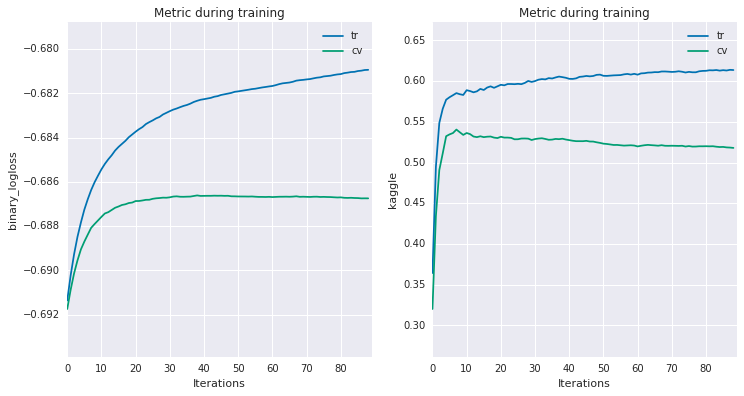

In [291]:
canvas(12,6)
fig, (ax0, ax1) = plt.subplots(1,2)
ax = lgb.plot_metric(evals_result, metric='binary_logloss', ax=ax0);
ax = lgb.plot_metric(evals_result, metric='kaggle', ax=ax1);
canvas(12,12)

In [236]:
raise Stop()

Stop: 

In [292]:
P['model'] = lgb_model.predict(F_)*2-1

In [310]:
P['guess'] = P.model
P.guess = P.guess*(np.abs(P.guess)>=0.1)

In [311]:
# ideal impossible strategies
#dayguess = P.groupby('time').apply(lambda p: ((p.upDown*p.absVal).sum()>0)*2-1)
#P.guess = P.time.map(dayguess)

In [312]:
P['trade'] = P.guess*P.upDown1*P.absVal1

0.5177098607481311


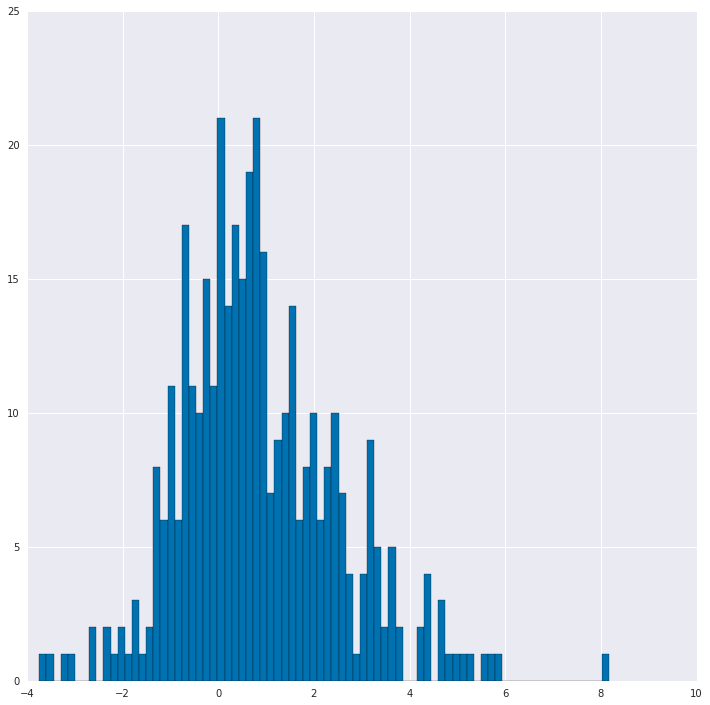

In [313]:
daily = P[ho].groupby('time').trade.sum()
print(daily.mean()/daily.std(ddof=0))
plt.hist(daily, bins=80);

In [ ]:
raise Stop()

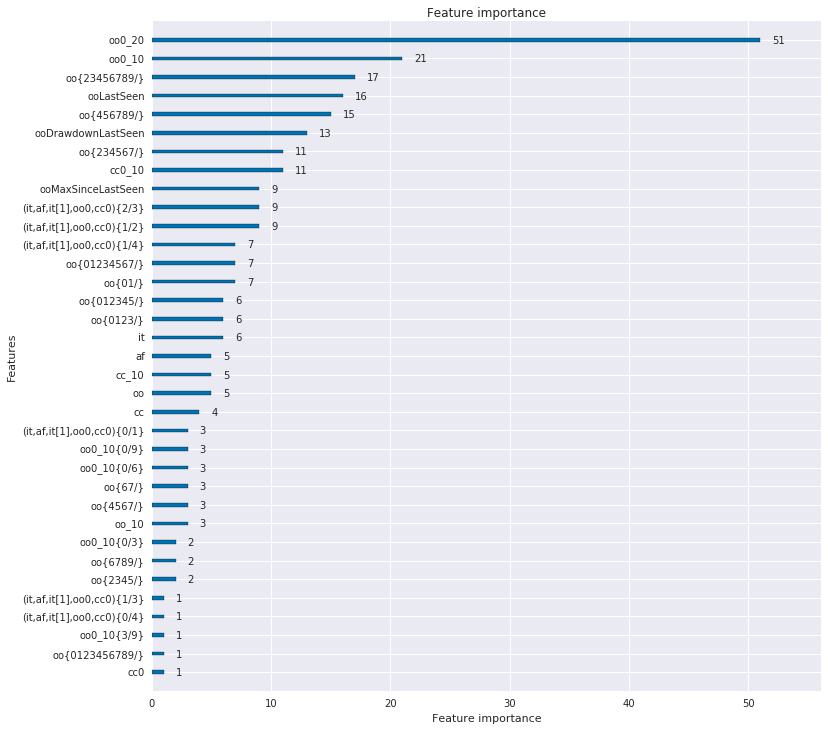

In [297]:
lgb.plot_importance(lgb_model);

# SCRATCH

In [43]:
a = O(i=0)
b = O(i=555)

In [59]:
for i in range(2500):
    o = a
    m = test[o.i][0]
    add_basic_features(M=m)
    m = m[~m.assetCode.isna()]
    assetCodeIndexedDf.join(m.set_index('assetCode'))
    #w = m.pivot('time','assetCode')
    if i%100==0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400


KeyboardInterrupt: 

In [61]:
guy = assetCodeIndexedDf.join(m.set_index('assetCode'))

In [12]:
{4:5}(({5:7}))

AttributeError: 'dict' object has no attribute 'extend'

In [28]:
for i in range(len(test)):
    assert (test[0][0].assetCode==test[0][2].assetCode).all()

In [34]:
pd.DataFrame([np.asarray([5,6,7]),np.asarray([2,0,9])],columns=[0,1,2],index=['one','two']).T[...]

KeyError: Ellipsis

In [53]:
guy = test[0][2].copy()
guy.index = test[0][2].assetCode.astype(assetCodeCategorical)
guy = guy[~guy.index.isna()]
guyguy = test[100][2].copy()
guyguy.index = test[100][2].assetCode.astype(assetCodeCategorical)
guyguy = guyguy[~guyguy.index.isna()]
print(lens(guy,guyguy))
pd.concat([guyguy,guy],axis=0).index.isna().any()

(1821, 1774)


False

In [59]:
guy

,assetCode,confidenceValue
assetCode,,
A.N,A.N,0.0
AA.N,AA.N,0.0
AAL.O,AAL.O,0.0
AAN.N,AAN.N,0.0
AAP.N,AAP.N,0.0
AAPL.O,AAPL.O,0.0
ABB.N,ABB.N,0.0
ABBV.N,ABBV.N,0.0
ABC.N,ABC.N,0.0


In [58]:
test[100][2].reset_index()

,index,assetCode,confidenceValue
0,0,A.N,0.0
1,1,AA.N,0.0
2,2,AAL.O,0.0
3,3,AAN.N,0.0
4,4,AAOI.O,0.0
5,5,AAP.N,0.0
6,6,AAPL.O,0.0
7,7,AAT.N,0.0
8,8,AAXN.O,0.0
9,9,ABB.N,0.0


dict_keys([{.assetName}, {.volume}, {.close}, {.open}, {.returnsClosePrevRaw1}, {.returnsOpenPrevRaw1}, {.returnsClosePrevMktres1}, {.returnsOpenPrevMktres1}, {.returnsClosePrevRaw10}, {.returnsOpenPrevRaw10}, {.returnsClosePrevMktres10}, {.returnsOpenPrevMktres10}, {.returnsOpenNextMktres10}, {.universe}, {.cc}, {.oo}, {.cc0}, {.oo0}, {.cc_10}, {.oo_10}, {.cc0_10}, {.oo0_10}, {.pseudo_target}, {.assetName_}, {.volume_}, {.close_}, {.open_}, {.returnsClosePrevRaw1_}, {.returnsOpenPrevRaw1_}, {.returnsClosePrevMktres1_}, {.returnsOpenPrevMktres1_}, {.returnsClosePrevRaw10_}, {.returnsOpenPrevRaw10_}, {.returnsClosePrevMktres10_}, {.returnsOpenPrevMktres10_}, {.returnsOpenNextMktres10_}, {.universe_}, {.cc_}, {.oo_}, {.cc0_}, {.oo0_}, {.cc_10_}, {.oo_10_}, {.cc0_10_}, {.oo0_10_}, {.pseudo_target_}, {.df}, {.af}, {.it}, 'oo{01/}', 'oo{0123/}', 'oo{012345/}', 'oo{01234567/}', 'oo{0123456789/}', 'oo{23/}', 'oo{2345/}', 'oo{234567/}', 'oo{23456789/}', 'oo{45/}', 'oo{4567/}', 'oo{456789/}', '

In [81]:
M.head()[[]]

""
0
1
2
3
4
